# Normalizing Flows notebook demonstration

#### Setting environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torch import distributions
import torch.nn.functional as F
from scipy.linalg import lu

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)


c:\Users\vitor\anaconda3\envs\ml_env\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Não foi possível encontrar o procedimento especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


#### Testing ELBO

In [2]:
# Define true distribution (p)
true_mu, true_sigma = 0, 1  # Mean and standard deviation

# Define a range of values for z
z = np.linspace(-5, 5, 1000)

# Convert true distribution parameters to torch tensors
true_mu_torch = torch.tensor(true_mu, dtype=torch.float32)
true_sigma_torch = torch.tensor(true_sigma, dtype=torch.float32)

# Initialize approximate posterior (q) parameters
approx_mu = torch.tensor(2.0, requires_grad=True)
approx_sigma = torch.tensor(1.5, requires_grad=True)

# Define the number of Monte Carlo samples
num_samples = 1000

In [3]:
# Reparameterization trick
def reparameterize(mu, sigma, num_samples):
    epsilon = torch.randn(num_samples)
    return mu + sigma * epsilon

def calculate_elbo(true_mu, true_sigma, approx_mu, approx_sigma, num_samples):
    z_samples = reparameterize(approx_mu, approx_sigma, num_samples)
    p_log_prob = -0.5 * (((z_samples - true_mu) / true_sigma) ** 2 + torch.log(2 * torch.pi * true_sigma ** 2))
    q_log_prob = -0.5 * (((z_samples - approx_mu) / approx_sigma) ** 2 + torch.log(2 * torch.pi * approx_sigma ** 2))
    elbo = torch.mean(p_log_prob - q_log_prob)
    return elbo

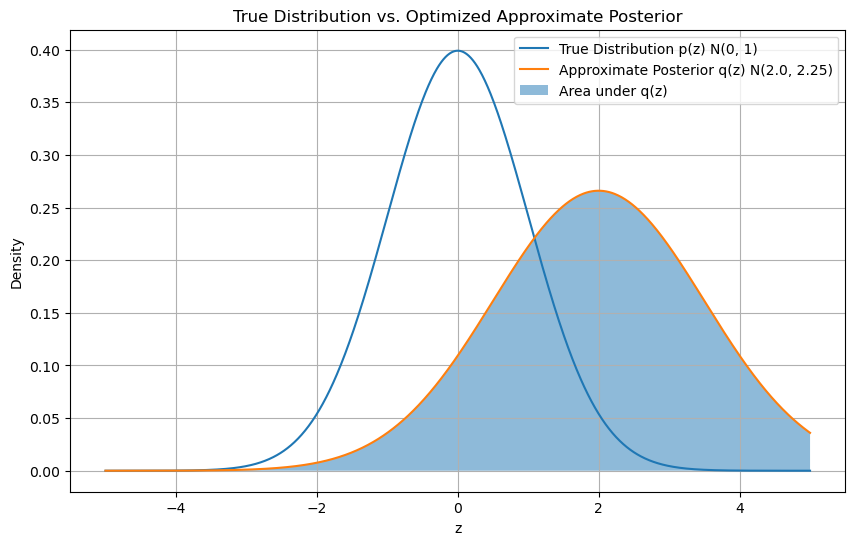

Initial ELBO: -2.3425350189208984
Initial mu: 2.0
Final sigma: 1.5


In [4]:
# Plot the distributions after optimization
true_dist = norm(true_mu, true_sigma)
approx_dist = norm(approx_mu.detach().numpy(), approx_sigma.detach().numpy())

elbo = calculate_elbo(true_mu_torch, true_sigma_torch, approx_mu, approx_sigma, num_samples)

plt.figure(figsize=(10, 6))
plt.plot(z, true_dist.pdf(z), label=f'True Distribution p(z) N({true_mu}, {true_sigma**2})')
plt.plot(z, approx_dist.pdf(z), label=f'Approximate Posterior q(z) N({approx_mu.detach().numpy()}, {approx_sigma.detach().numpy()**2})')
plt.fill_between(z, approx_dist.pdf(z), alpha=0.5, label='Area under q(z)')
plt.title('True Distribution vs. Optimized Approximate Posterior')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

print(f"Initial ELBO: {elbo}")
print(f"Initial mu: {approx_mu.detach().numpy()}")
print(f"Final sigma: {approx_sigma.detach().numpy()}")

#### Demonstrating base architecture of DLGMs with inference networks

In [5]:
# Define the Encoder (Inference Network)
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
    
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Define the Decoder (Generative Model)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)
    
    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_reconstructed = torch.sigmoid(self.fc2(h))
        return x_reconstructed

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar

    def elbo_loss(self, x, x_reconstructed, mu, logvar):
        recon_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_divergence
    
# Define the dimensions for showcasing the VAE srtucture
input_dim = 512
latent_dim = 16
vae = VAE(input_dim, latent_dim)

# Print the VAE architecture
print(vae)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (fc_mu): Linear(in_features=256, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=16, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
  )
)
